# Exploratory Data Analysis Disaster Tweets

In [1]:
# Import Statements
import pprint
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import defaultdict

import nltk  
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore")

### Custom Data Loading

In [2]:
# Load Train and Test Data
df_train = pd.read_csv('train.csv', 
                dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

# Print Shape and Memory Usage
print('Train Set Shape: ', df_train.shape)
print('Train Set Memory Usage: {:.2f} MB'.format(
    df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape: ', df_test.shape)
print('Test Set Memory Usage: {:.2f} MB'.format(
    df_test.memory_usage().sum() / 1024**2))

Train Set Shape:  (7613, 5)
Train Set Memory Usage: 0.20 MB
Test Set Shape:  (3263, 4)
Test Set Memory Usage: 0.08 MB


In [3]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB
None


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Preprocessing

### Missing Values
Both training and test set have same ratio of missing values in `keyword` and `location`.
- **0.8%** of `keyword` is missing in both training and test set
- **33%** of `location` is missing in both training and test set

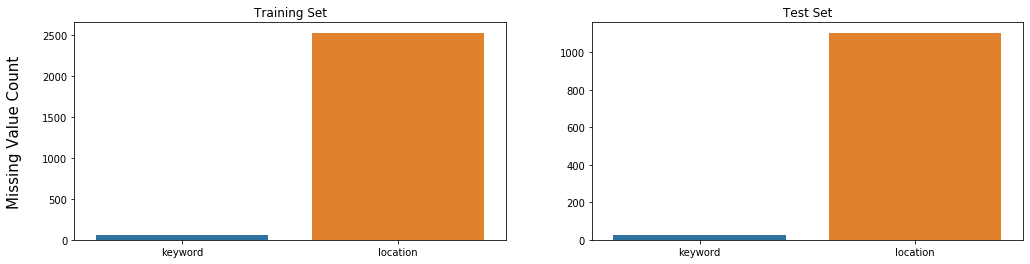

In [5]:
# Plot Missing data ratio in Training and Test sets
fig = plt.figure(figsize=(17, 4))

fig.add_subplot(1, 2, 1)
plt.title('Training Set')
plt.ylabel("Missing Value Count", size=15, labelpad=20)
sns.barplot(x=df_train[['keyword', 'location']].isnull().sum().index,
           y=df_train[['keyword', 'location']].isnull().sum().values)

fig.add_subplot(1, 2, 2)
plt.title('Test Set')
sns.barplot(x=df_test[['keyword', 'location']].isnull().sum().index,
           y=df_test[['keyword', 'location']].isnull().sum().values)

plt.show()

In [6]:
df_train['keyword'].fillna('no_keyword', inplace=True)
df_test['keyword'].fillna('no_keyword', inplace=True)
df_train['location'].fillna('no_location', inplace=True)
df_test['location'].fillna('no_location', inplace=True)

### Cardinality and Target Distribution
Locations are user inputs. That's why `location` has too many unique values and it cannot be used as a feature.

However, `keyword` can be used as a feature because some of the words can be used in one context only. Every single keyword in training set exists in test set.

In [7]:
# Cardinality of Keyword and Location in Training and Test set
print('Number of unique values in keyword = {} (Training) - {} (Test)'.format(
df_train['keyword'].nunique(), df_test['keyword'].nunique()))

print('Number of unique values in location = {} (Training) - {} (Test)'.format(
df_train['location'].nunique(), df_test['location'].nunique()))

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


Since `keyword` is a good feature, let's look at the **Target Distribution in Keywords in Training Dataset**.

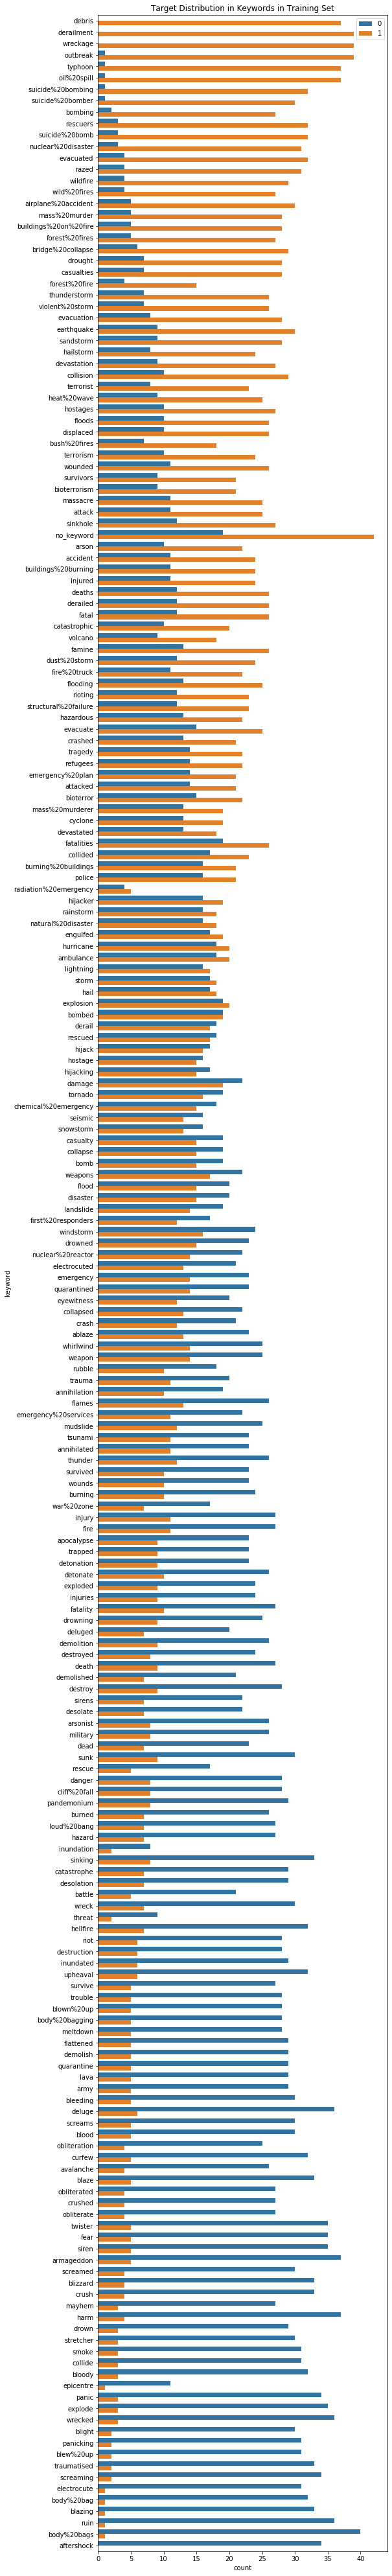

In [8]:
# Target Distribution in Keywords in Training Dataset
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72))

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
             hue=df_train.sort_values(by='target_mean', ascending=False)['target'])
plt.legend(loc='upper right')
plt.title('Target Distribution in Keywords in Training Set')
plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

### Meta Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. The meta features used for the analysis are:

- `word_count` number of words in text
- `unique_word_count` number of unique words in text
- `stop_word_count` number of stop words in text
- `url_count` number of urls in text
- `mean_word_length` average character count in words
- `char_count` number of characters in text
- `punctuation_count` number of punctuations in text
- `hashtag_count` number of hashtags (#) in text
- `mention_count` number of mentions (@) in text

Now we will look at the distribution of each meta feature in training and test set.

In [9]:
# word_count
df_train['word_count'] = df_train['text'].apply(
    lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(
    lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(
    lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(
    lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
df_test['stop_word_count'] = df_test['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
df_train['url_count'] = df_train['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(
    lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(
    lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))


# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

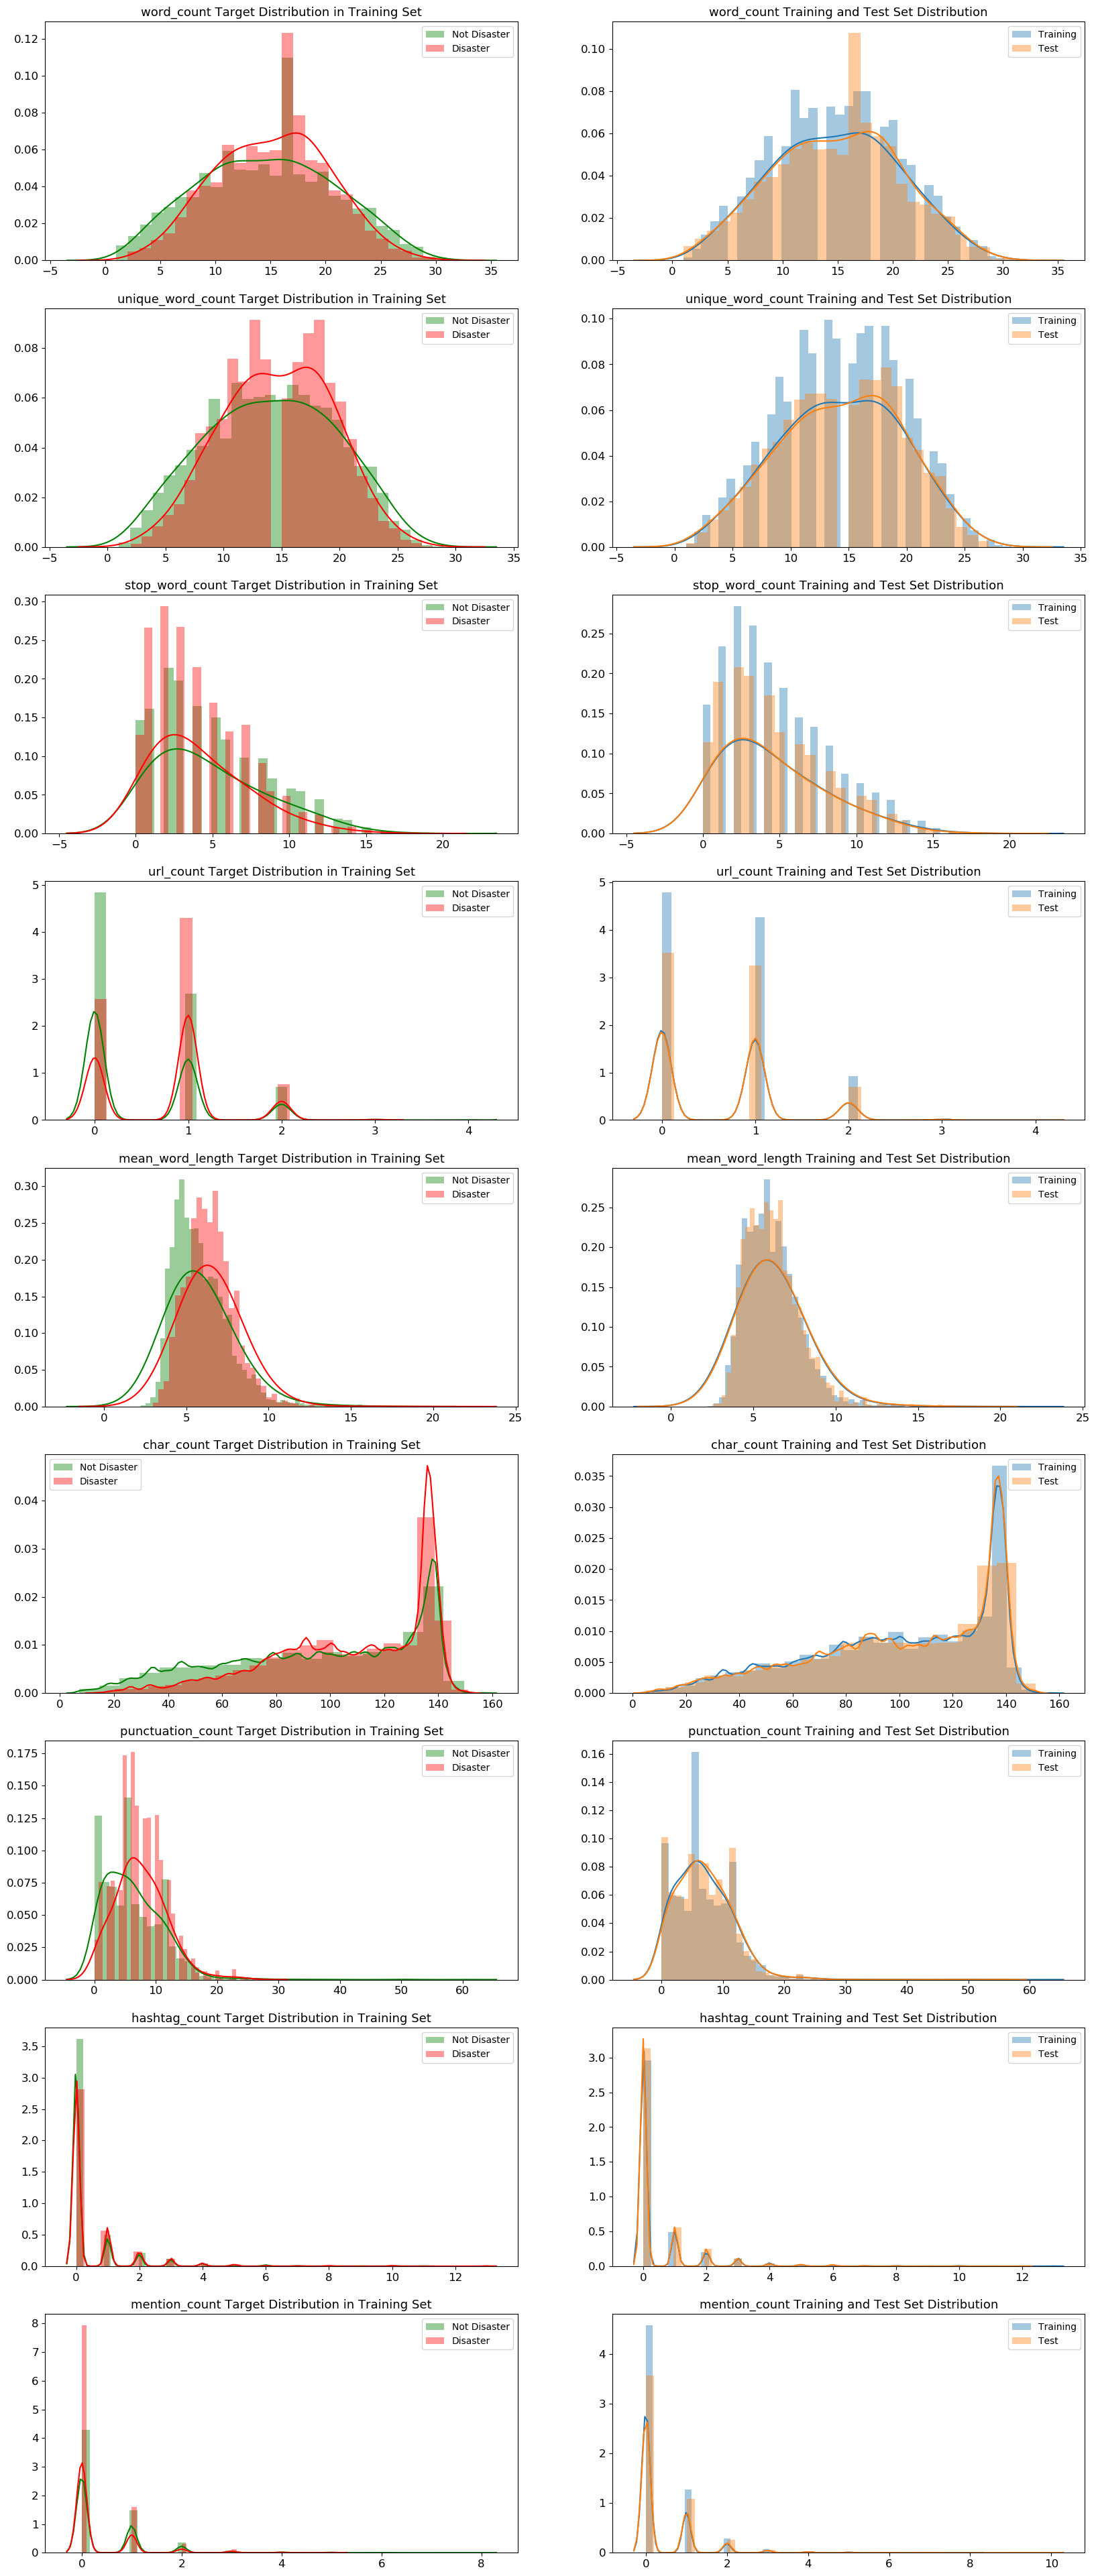

In [10]:
META_FEATURES = [('word_count', 1.5), ('unique_word_count', 1.5), ('stop_word_count', 1.5), ('url_count', 0.1), ('mean_word_length', 1.5),
                ('char_count', 1.5), ('punctuation_count', 1.5), ('hashtag_count', 0.1), ('mention_count',0.1)]

DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(META_FEATURES), 
                         figsize=(20,50), dpi=100) 

for i, feature in enumerate(META_FEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature[0]], 
                 label='Not Disaster', ax=axes[i][0], color="green",
                kde_kws={'bw': feature[1]})
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature[0]], 
                 label='Disaster', ax=axes[i][0], color="red",
                kde_kws={'bw': feature[1]})
    
    sns.distplot(df_train[feature[0]], label='Training', ax=axes[i][1],
                kde_kws={'bw': feature[1]})
    sns.distplot(df_test[feature[0]], label='Test', ax=axes[i][1],
                kde_kws={'bw': feature[1]})
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature[0]} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature[0]} Training and Test Set Distribution', fontsize=13)
    
plt.show()    

From the distribution graphs above, some of the meta features are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

### Target Count and Distribution
Class distribution in dataset helps to examine any biasness the dataset has due to imbalance classes that can cause the model to not perform well.

Let's analyze the **Disaster** and **Not Disaster** class distribution in Training Set 

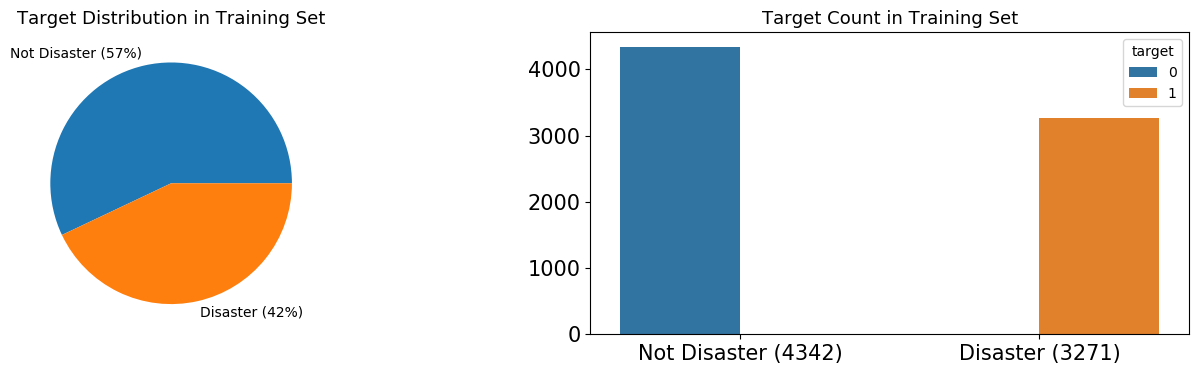

In [22]:
fig = plt.figure(figsize=(17,4), dpi=100)
# Plot Pie 
fig.add_subplot(1,2,1)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title("Target Distribution in Training Set", fontsize=13)
train_target_distrib = df_train.groupby('target').count()['id']
not_disaster_percent = int((train_target_distrib[0] / (train_target_distrib[0] + train_target_distrib[1])) * 100)
disaster_percent = int((train_target_distrib[1] / (train_target_distrib[0] + train_target_distrib[1])) * 100)
train_target_distrib.plot(kind='pie', labels=['Not Disaster ('+ str(not_disaster_percent) +'%)', 
                        'Disaster ('+ str(disaster_percent) +'%)'])
plt.ylabel('')

# Target Count in Training Set
fig.add_subplot(1,2,2)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title("Target Count in Training Set", fontsize=13)
sns.countplot(x=df_train['target'], hue=df_train['target'])
plt.xticks(ticks=[0,1], labels=['Not Disaster ('+ str(train_target_distrib[0]) +')', 
                                'Disaster ('+ str(train_target_distrib[1]) +')'])
plt.ylabel('')
plt.xlabel('')

plt.show()

### Generate Ngrams
Ngrams are a set of co-occuring words within a given window. It can help in deciding which N-grams can be chunked together to form single entities.

In [12]:
# Generate N-grams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split() if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

#### Unigrams
Let's analyze top 100 most frequent unigrams in both classes **Disaster Tweets** and **Non Disaster Tweets**.

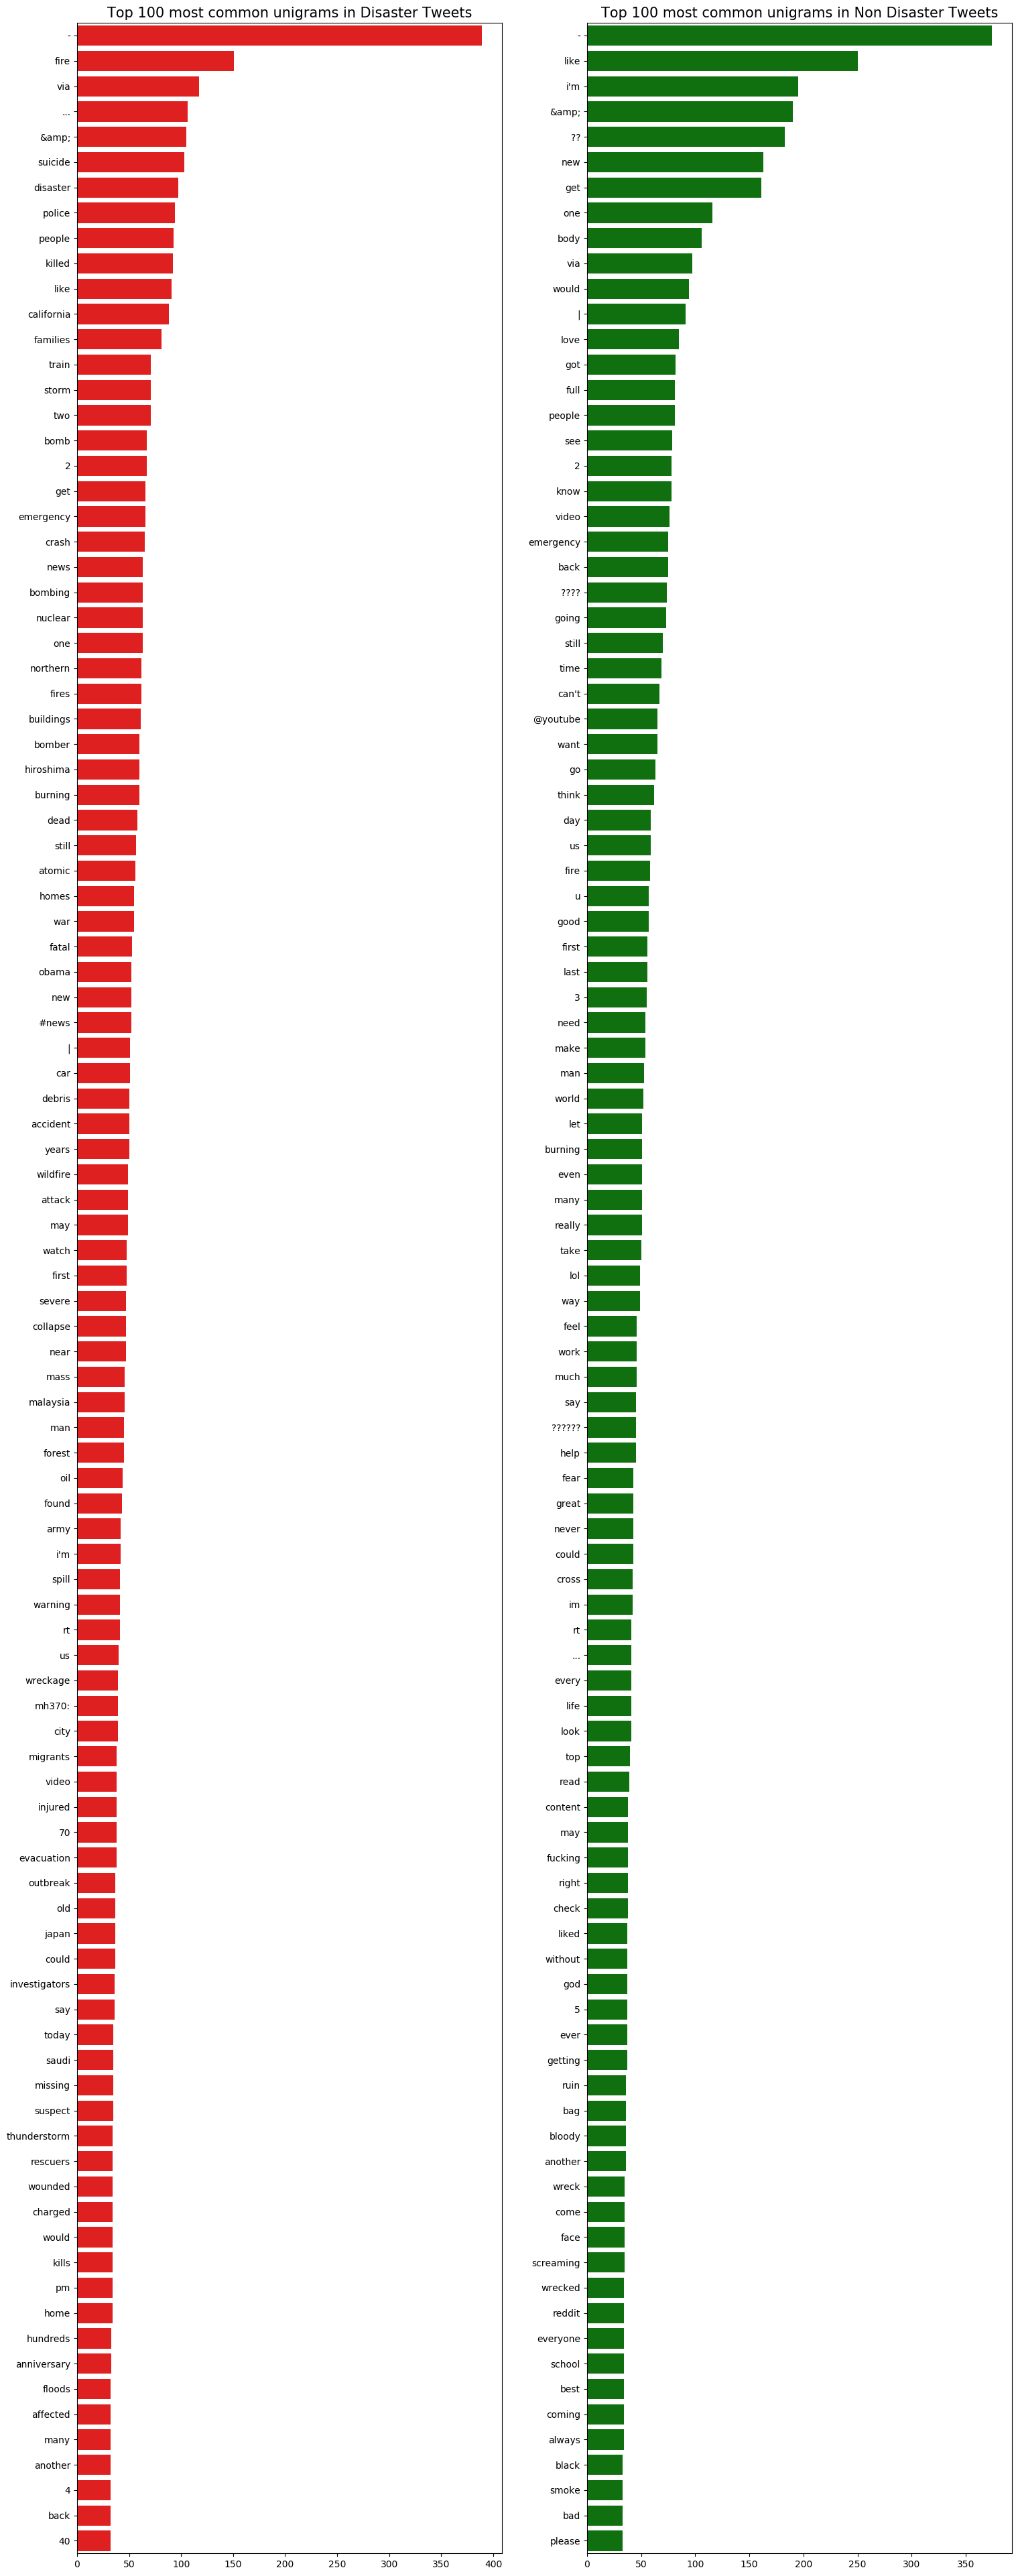

In [13]:
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Plot Unigrams of Disaster Tweets
N = 100
fig = plt.figure(figsize=(18,50), dpi=100)
fig.add_subplot(1,2,1)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
sns.barplot(y=df_disaster_unigrams[0].values[:N], 
            x=df_disaster_unigrams[1].values[:N], color='red')
plt.xlabel('')
plt.ylabel('')

# Plot Unigrams of Non Disaster Tweets
fig.add_subplot(1,2,2)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common unigrams in Non Disaster Tweets', fontsize=15)
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], 
            x=df_nondisaster_unigrams[1].values[:N], color='green')
plt.xlabel('')
plt.ylabel('')

plt.show()

Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

#### Bigrams

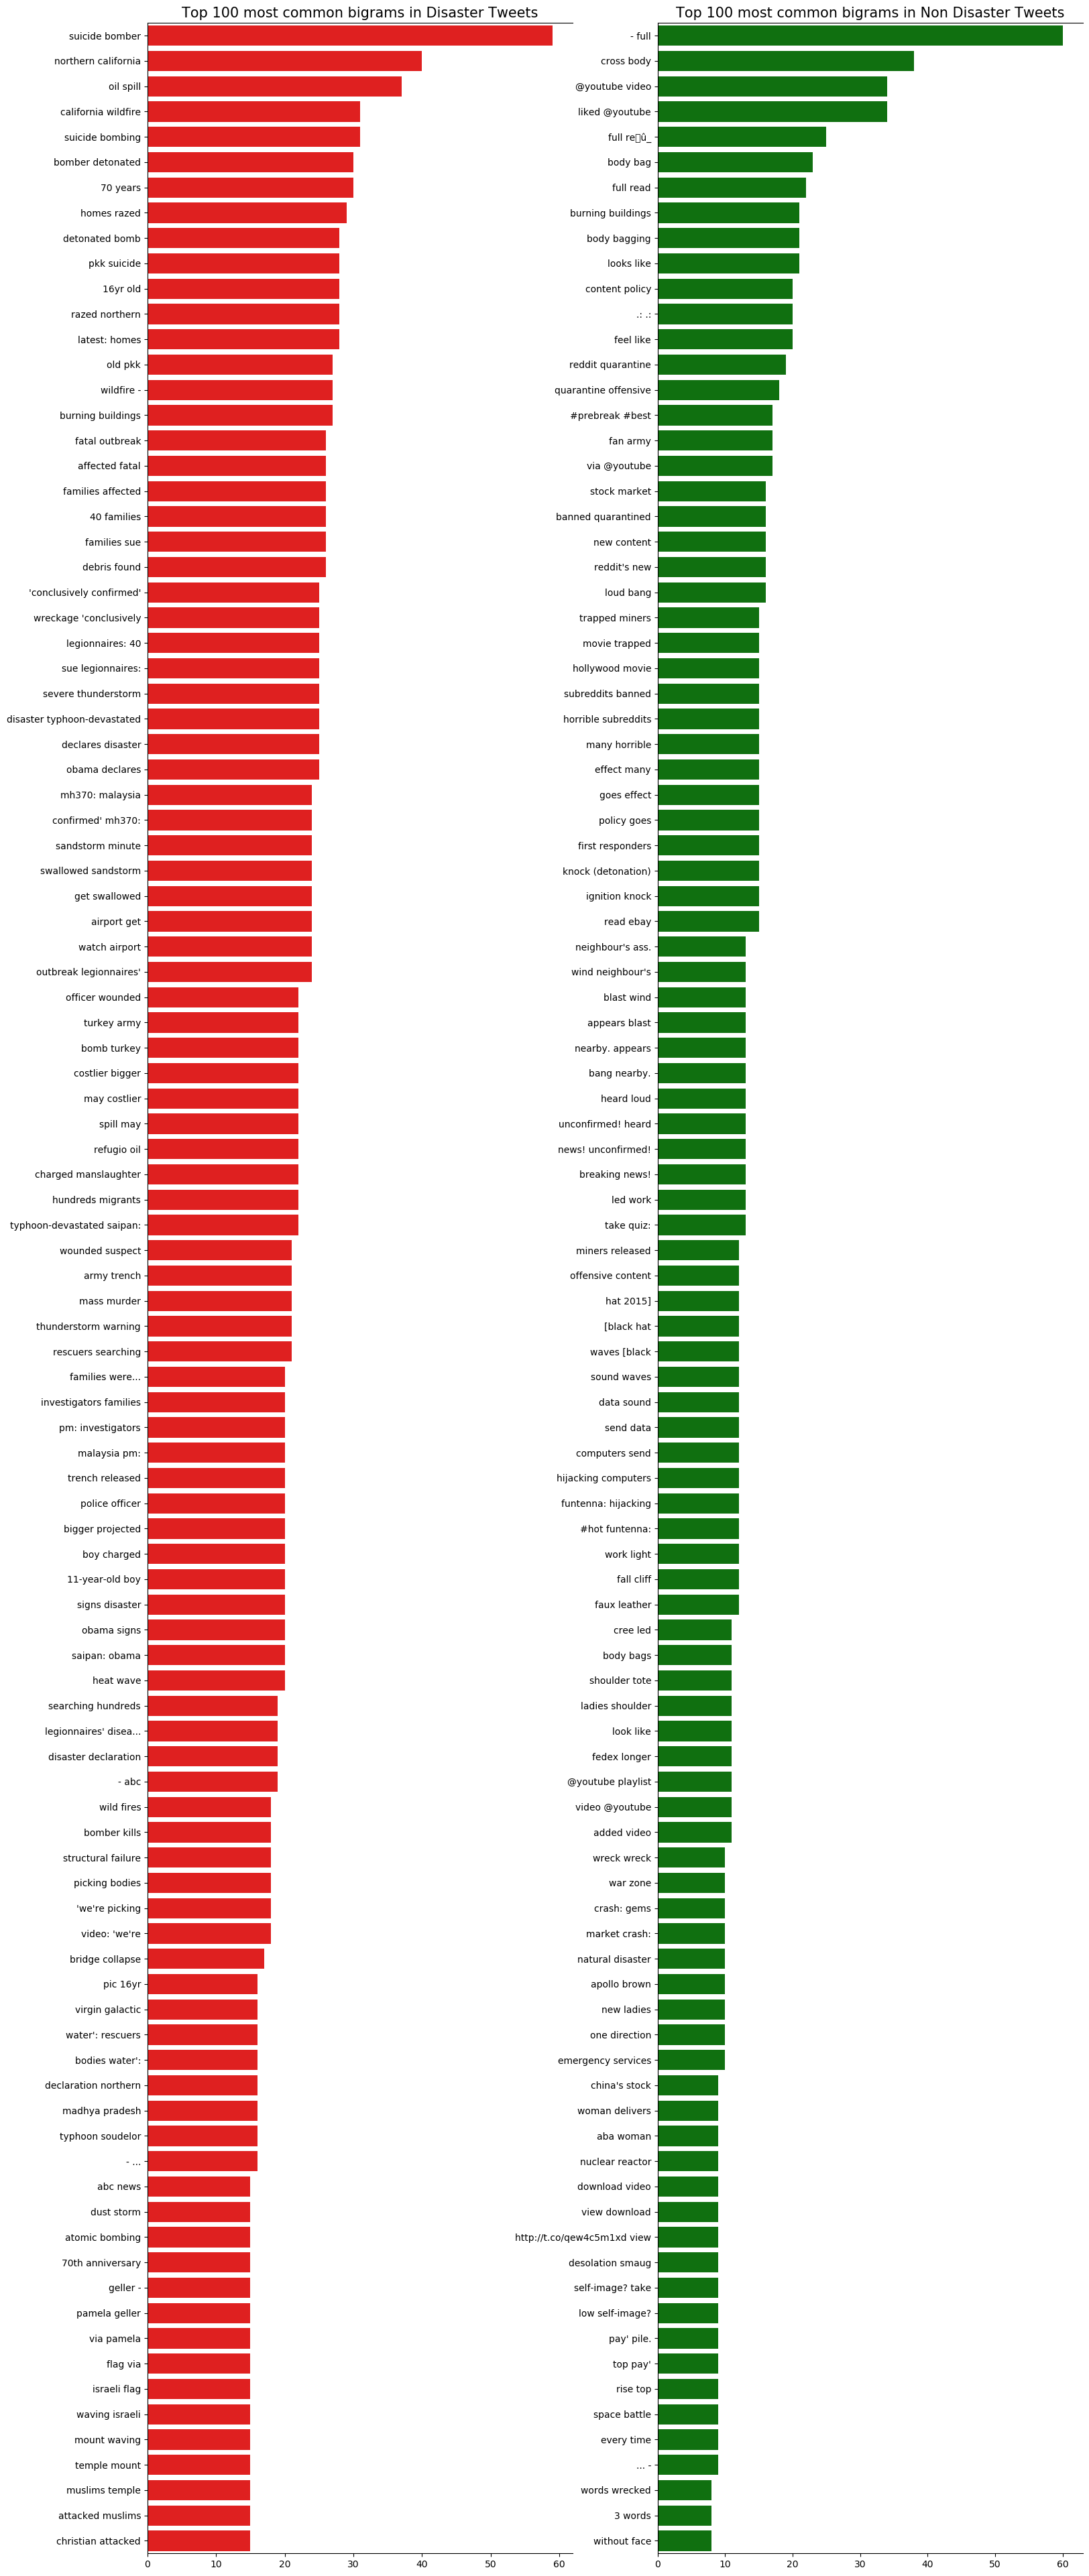

In [32]:
# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, 2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, 2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Plot Bigrams of Disaster Tweets
N = 100
fig = plt.figure(figsize=(18,50), dpi=100)
fig.add_subplot(1,2,1)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
sns.barplot(y=df_disaster_bigrams[0].values[:N], 
            x=df_disaster_bigrams[1].values[:N], color='red')
sns.despine(top=False, right=True, left=False, bottom=False)
plt.xlabel('')
plt.ylabel('')

# Plot Bigrams of Non Disaster Tweets
fig.add_subplot(1,2,2)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common bigrams in Non Disaster Tweets', fontsize=15)
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], 
            x=df_nondisaster_bigrams[1].values[:N], color='green')
sns.despine(top=False, right=True, left=False, bottom=False)
plt.xlabel('')
plt.ylabel('')

plt.show()

There are no common bigrams exist in **both classes** because the context is clearer.

Most common bigrams in **disaster tweets** are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

Most common bigrams in **non-disaster tweets** are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

#### Trigrams

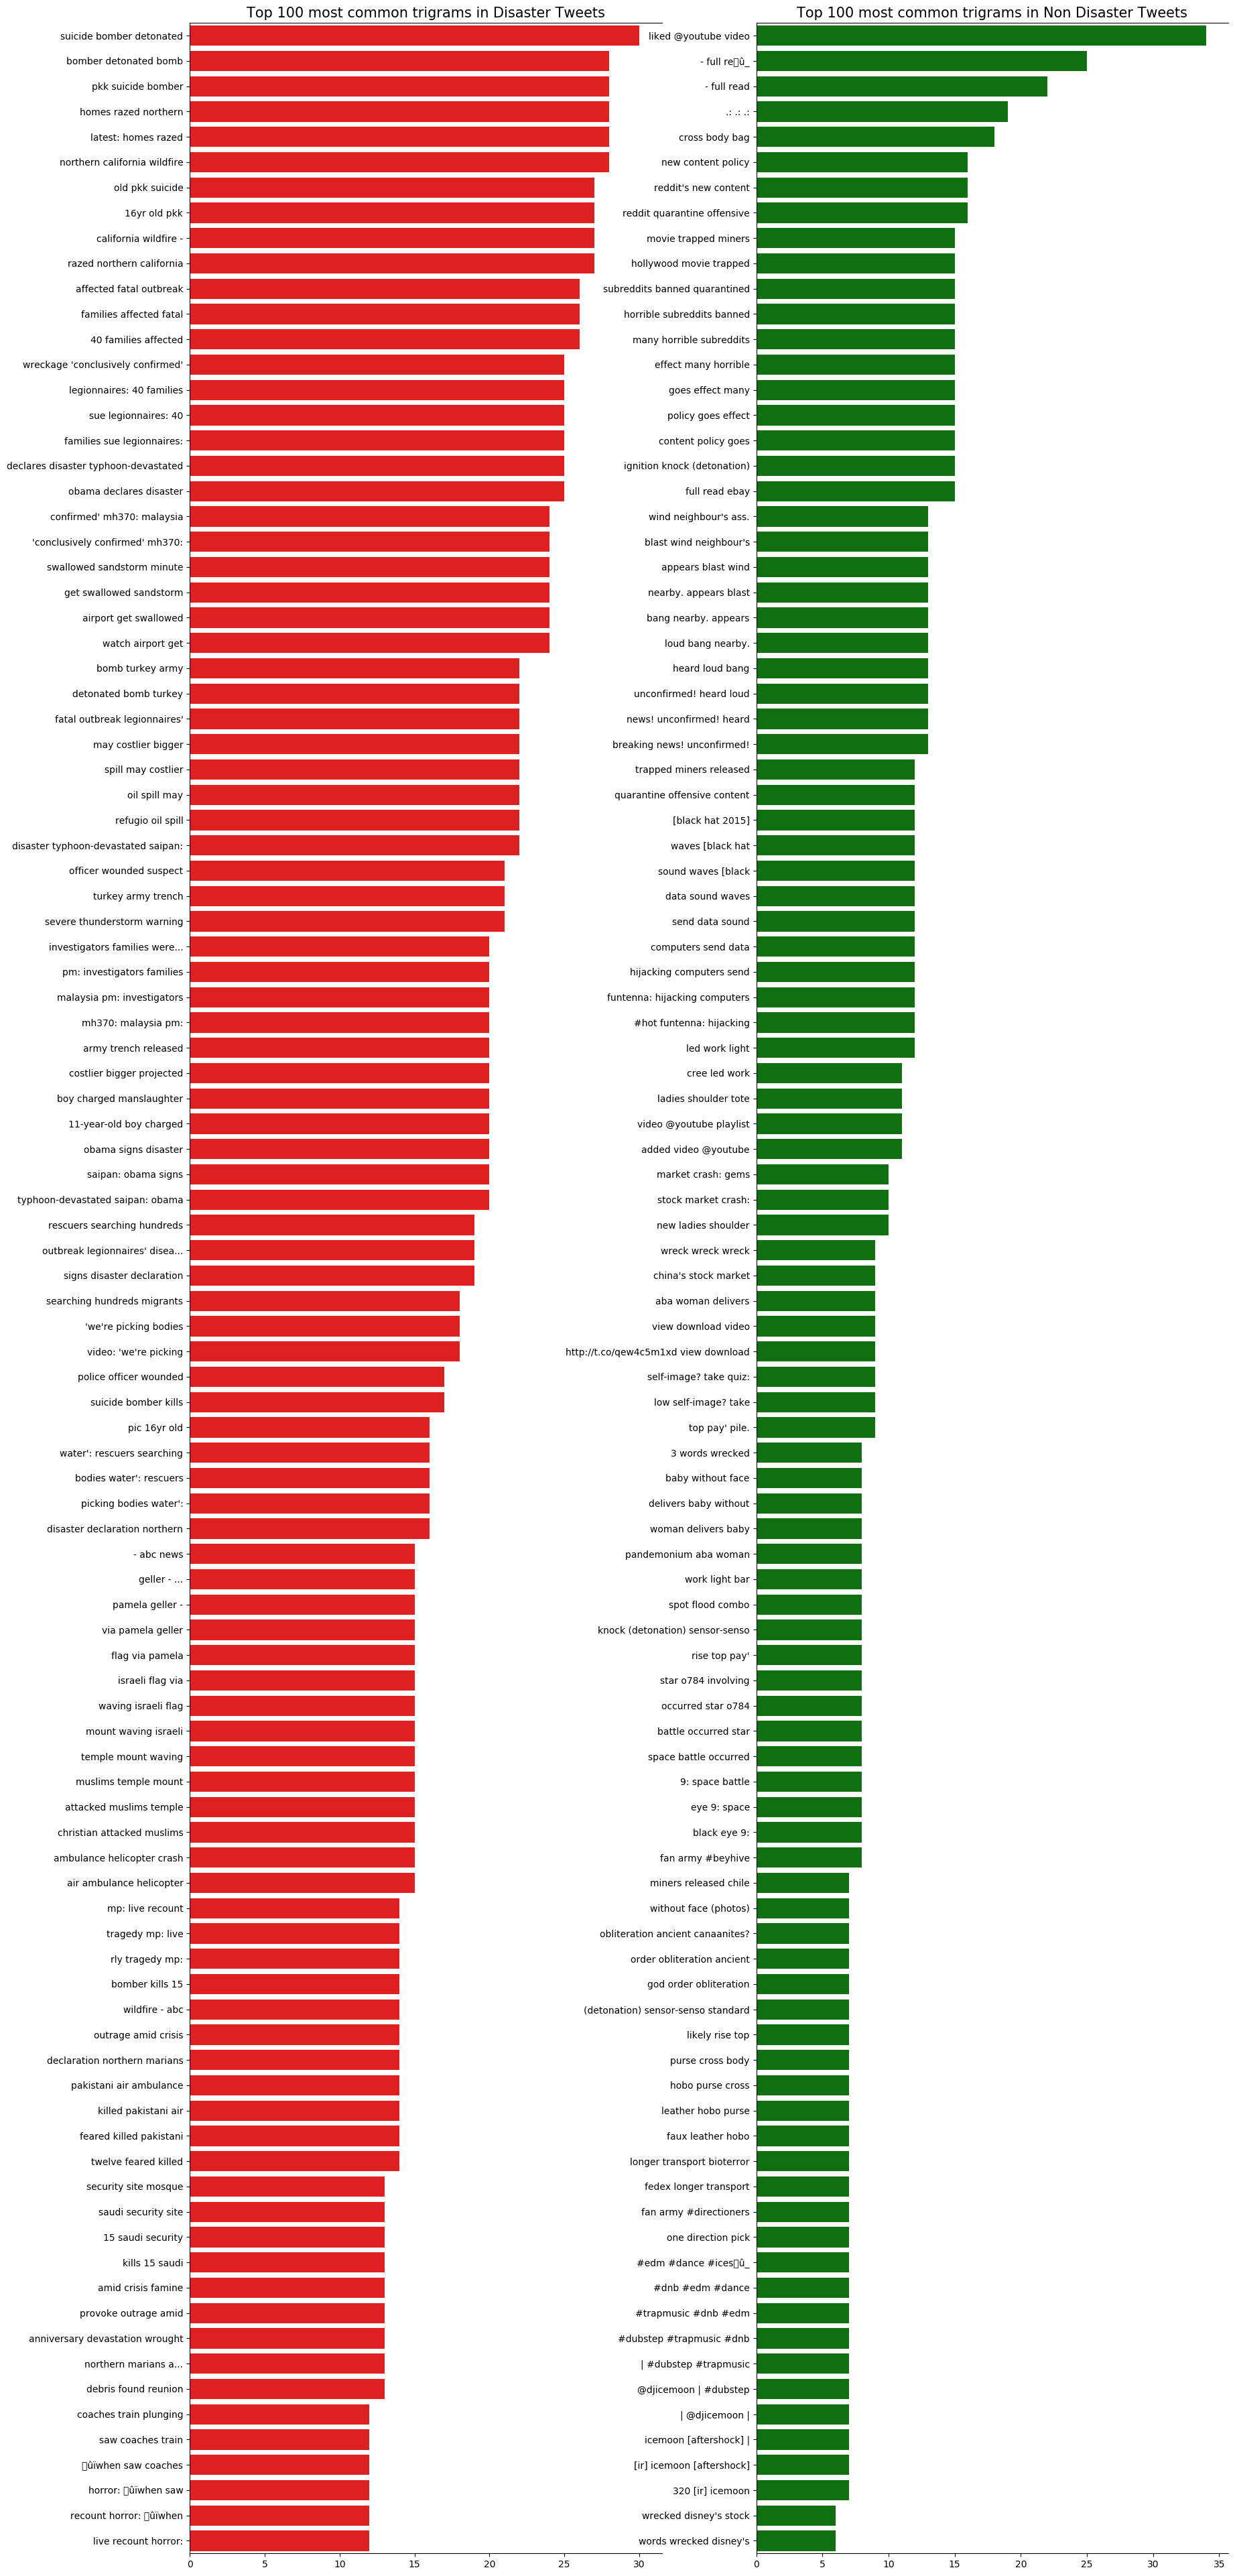

In [34]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, 3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, 3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

# Plot Trigrams of Disaster Tweets
N = 100
fig = plt.figure(figsize=(20,50), dpi=100)
fig.add_subplot(1,2,1)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
sns.barplot(y=df_disaster_trigrams[0].values[:N], 
            x=df_disaster_trigrams[1].values[:N], color='red')
sns.despine(top=False, right=True, left=False, bottom=False)
plt.xlabel('')
plt.ylabel('')

# Plot Trigrams of Non Disaster Tweets
fig.add_subplot(1,2,2)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title(f'Top {N} most common trigrams in Non Disaster Tweets', fontsize=15)
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], 
            x=df_nondisaster_trigrams[1].values[:N], color='green')
sns.despine(top=False, right=True, left=False, bottom=False)
plt.xlabel('')
plt.ylabel('')

plt.show()

There are no common trigrams exist in **both classes** because the context is clearer.

Most common trigrams in **disaster tweets** are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in **non-disaster tweets** are also very similar to bigrams, and they contain even more punctuations.

## Embeddings and Text Cleaning

### Embeddings Coverage
When you have pre-trained embeddings, doing standard preprocessing steps might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, `train vocab` and `test vocab` are created by counting the words in tweets.

Text cleaning is based on the embeddings below:
- GloVe-300d-840B 
- FastText-Crawl-300d-2M